In [ ]:
## Import neccessary packages
import pandas as pd
from csv import reader
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
## Reading dataset
tennis = pd.read_csv("tennis.txt",sep=",")
car = pd.read_csv("car_evaluation.csv",header=None)
car.columns =['buying', 'maint', 'doors', 'persons','lug_boot','safety','class']
car["class"] = np.where(car["class"] == "unacc","0","1")

## ***I> Reading dataset and EDA***

In [ ]:
## Checking dataset on number of values in each values, missing value, outliers

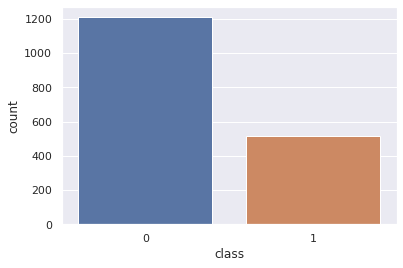

In [ ]:
# Show the number values of each column
sns.set(style="darkgrid")
ax = sns.countplot(x="class", data=car)

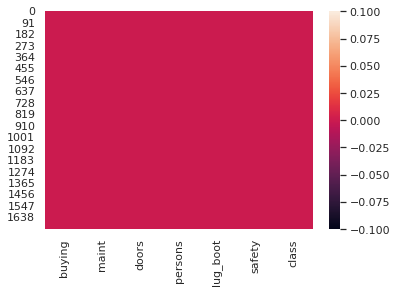

In [ ]:
# Show the missing values of each column
sns.heatmap(car.isnull(),\
            # yticklabels=False,cbar=False,cmap="blue"
            )

## ***II> Writing decision tree from scratch***

In [ ]:
def train_test(orginal_dataset,percent):
  '''
  This function is to split dataset into training and testing data and differentiate variable columns and class column
  Orginal_dataset: the data need to be splited
  Persent: how many percent to split training set
  '''
  ## Split dataset into training and testing data
  sz = len(orginal_dataset) ## Counting number of row in orginal_dataset
  cut = int(percent * sz)
  shuffled_l = orginal_dataset.sample(frac=1) ## shiffle the dataset
  train = shuffled_l[:cut] # first percent% of dataset will be training set
  test = shuffled_l[cut:] # last (1-percent)% of dataset will be testing set

  return train,test

In [ ]:
class Tree_node:
  def __init__(self,
               nodeId = None,
               nodeType= None,
               split_feature= None,
               split_value= None,
               left= None,
               right= None,
               classValue= None):
    self.nodeId = nodeId
    self.nodeType = nodeType
    self.split_feature = split_feature
    self.split_value = split_value
    self.left = left
    self.right = right
    self.classValue = classValue


  def add_node(self,tree):
    '''
    This function adds a node by add a new line into a tree dataset (tree dataset will create empty when using function model_training after a split
    if we do not want to split the dataset anymore, we will consider it as a leaf and show it's ID, TypeNode = Leaf and classes which dominaed in the dataset
    if we continue split the dataset, we will consider it as a Decision and show it's ID, TypeNode = Decision and column+value to create the next split and the position of left and right side
    '''
    if (self.nodeType == "Leaf"):
      tree.loc[len(tree)+1] = (self.nodeId,self.nodeType,np.NaN,np.NaN,np.NaN,np.NaN,self.classValue)
    elif (self.nodeType == "Decision"):
      tree.loc[len(tree)+1] = (self.nodeId,self.nodeType,self.split_feature,self.split_value,self.left,self.right,np.NaN)
    return tree

In [ ]:
class DecisionTree:
  def __init__(self,
               max_depth= 3,
               debug = None):
    self.max_depth= max_depth
    self.debug = debug
    self.model = None

  def Gini_index(self,dataset,class_column):
    '''
    This function computes the impurity of the key column
    formula of impurity = 1 - [(n1/(n1+n2+...+nn))^2 + n2/(n1+n2+...+nn))^2 + .... + nn/(n1+n2+...+nn))^2]
    '''
    ## Counting the number of each unique value in class column
    unique_list = dataset.groupby([class_column])[class_column].size().reset_index(name='count')
    ## Computing percent of value
    unique_list["percent"] = unique_list["count"].apply(lambda x: (x/len(dataset))**2)
    ## The impurity of the orginal data
    gini_impurity = 1 - sum(unique_list["percent"])
    return gini_impurity

  def information_gain(self,dataset,feature,value,class_column):
    '''
    This function computes the information gain after and before spliting for each value in each column
    formula of infformation gain = information_gain_before - average(information_gain_left+information_gain_right)
    '''
    ## Split the dataset into 2 subsets one equal to according variables (left) and one is not (right)
    left_tree = dataset[dataset[feature] == value]
    right_tree = dataset[dataset[feature] != value]

    ## Calculate impurity of the previous dataset and the left and right datasets
    gini_before = self.Gini_index(dataset,class_column)
    gini_left = self.Gini_index(left_tree,class_column)
    gini_right = self.Gini_index(right_tree,class_column)

    ## Calculate information gain based on impurity of the previous dataset and the left and right datasets
    info_gain = gini_before - ((gini_left+gini_right)/2)
    return info_gain


  def best_split(self,dataset,class_column):
    '''
    This function chooses a value which has the highest information gain in order to split the dataset
    '''
    ## Set up some first variables to compare and store result
    best_gain = -1
    best_feature = ""
    best_value = ""

    ## Loops over each value in each column until figure out which one has the best information gain and show it's column and name
    for column in dataset.drop([class_column],1).columns.tolist():
      splitted_feature = list(set(dataset[column]))
      for value in splitted_feature:
        infor_gain = self.information_gain(dataset,column,value,class_column)
        if (infor_gain > best_gain):
          best_gain = infor_gain
          best_feature = column
          best_value = value
    return best_gain,best_feature,best_value


  def model_training(self, dataset,class_column, tree, nodeId= 0, depth= 0):
    '''
    This function trains the model by using the functions above
    expected result: will have how many nodeIDs are created in which many Leafs and many Decisions,
    If decisons, name of column and value for the next split
    If leaf, name of class
    '''
    ## Compute impurity index for entire dataset
    impurity = self.Gini_index(dataset,class_column)

    ## Set up leaf variable if any row meet the requirement to become a leaf node
    leaf = Tree_node(
                      nodeId= nodeId,
                      nodeType= "Leaf",
                      split_feature = np.NaN,
                      split_value = np.NaN,
                      left= np.NaN, right= np.NaN,
                      classValue=  dataset[class_column].value_counts().idxmax()
                      )


    ## if impurity = 0 meaning that dataset contains only one type of class or no data in that dataset or the size of tree reached our expectation, the model will automatically add a leaf after ward
    if (impurity == 0) or (len(dataset) == 0) or (depth == self.max_depth):
      tree = leaf.add_node(tree = tree)
      return tree

    ## If the dataset does not meet the conditions above then it will be splitted
    split_infor = self.best_split(dataset,class_column)
    left_split = dataset.loc[dataset[split_infor[1]] ==  split_infor[2]]
    right_split = dataset.loc[dataset[split_infor[1]] !=  split_infor[2]]

    ## If there is not data in right or left datasets, the model will also add a leaf in that dataset afterward
    if (len(left_split) == 0) or (len(right_split) == 0):
      tree = leaf.add_node(tree = tree)
      return tree

    ## If left and right dataset still have data, the model will then add a decision to figure out the best value and column for the next split

    ## Set up decision variable if any row meet the requirement to become a decision node
    decision = Tree_node(
                    nodeId= nodeId,
                    nodeType= "Decision",
                    split_feature = split_infor[1],
                    split_value = split_infor[2],
                    left= np.NaN, right= np.NaN,
                    classValue = np.NaN
                    )

    tree = decision.add_node(tree = tree)

    ## the model will automatically split the tree for each side until meet first or second condition (which show their leaf), after a split the model will the order of node will increase 1 unit
    ## left branch
    next_node = tree["NODE"].apply(pd.to_numeric).max() + 1
    tree = self.model_training(dataset = left_split,
                        nodeId= next_node,
                        tree= tree,
                        depth= depth+1,
                        class_column= class_column
                        )

    tree.loc[tree["NODE"] == nodeId, "LEFT"] = next_node

    ## right branch
    next_node = tree["NODE"].apply(pd.to_numeric).max() + 1
    tree = self.model_training(dataset = right_split,
                        nodeId= next_node,
                        tree= tree,
                        depth= depth+1,
                        class_column= class_column
                        )
    tree.loc[tree["NODE"] == nodeId, "RIGHT"] = next_node
    return tree

  def fit(self, X, y):
        tree = pd.DataFrame(columns=["NODE","TYPE","SPLIT_FEATURE","SPLIT_VALUE","LEFT","RIGHT","CLASS_VALUE"])
        self.model = self.model_training(X, y, tree = tree)


  def _predict_one(self,row_to_predict):
    '''
    This function predicts the class of each row in the predict set after figure out which values to classify and predict the class of a row
    model: is the model we have from model_training function
    row_to_predict: a row we want to predict
    debug: to showcase the progress of the model
    '''
    ## Set up some first variables to compare
    curr_node_idx= 0
    curr_node = self.model[self.model["NODE"] == curr_node_idx]
    is_leaf = curr_node[curr_node["TYPE"] == "LEAF"]

    ## Loops over each best value from the training model to split
    while (curr_node.iloc[0]['TYPE'] != "Leaf"):
      test_feature = curr_node["SPLIT_FEATURE"]
      test_value = curr_node["SPLIT_VALUE"]
      if (self.debug):
        print("Node",curr_node_idx,":using",test_feature,"=",test_value,": is_leaf=",is_leaf)

      curr_node_idx =  np.where(row_to_predict[test_feature].values[0] == test_value,
                                curr_node["LEFT"].apply(pd.to_numeric),
                                curr_node["RIGHT"].apply(pd.to_numeric))

      curr_node_idx = curr_node_idx[0]
      curr_node = self.model[self.model["NODE"]==curr_node_idx]
      is_leaf = (curr_node[curr_node["TYPE"]=="LEAF"])

    if (self.debug):
        print("Found leaf!")

    return curr_node["CLASS_VALUE"].values

  def predict(self,pred_dataset):
    '''
    This function is to predict whole dataset by apply each row in the prediction dataset to _predict_one function
    pred_dataset: is the dataset we want to predict
    '''
    ## Convert best column for splitting to a list
    convert = self.model.groupby('SPLIT_FEATURE').agg(lambda x: list(x.dropna())).reset_index()
    list_of_split_feature = convert["SPLIT_FEATURE"].to_list()

    ## filter our neccessary column after training to predict
    instances = pred_dataset[list_of_split_feature]

    #### Predict a whole test dataset
    predictions = []
    for row in range(len(instances)):
      pred = self._predict_one(row_to_predict = instances.iloc[row])
      predictions.append(pred) # store it in a new column

    ## assign the prediction to prediction dataset
    pred_dataset["predictions"] = predictions
    ## convert data to string
    pred_dataset["predictions"] = pred_dataset["predictions"].apply(lambda row : " ".join(map(str,row)))

    return pred_dataset

## ***III> Validate the result***

In [ ]:
def validation(dataset,class_column):
  '''
  This function validates the prediction by showing accuracy and Precision and Recall
  '''
  ## Calculate Accuracy of the dataset
  dataset['comparison'] = np.where(dataset[class_column] == dataset['predictions'], "True", "False")
  Accuracy = (len(dataset[dataset['comparison'] == "True"])/ \
              (len(dataset[dataset['comparison'] == "True"])+ \
                len(dataset[dataset['comparison'] == "False"])))*100

  ## Calculate Precision and recall of the dataset (Precision = TP/(TP+FP), Recall = TP/(TP+FN))
  dataset['Confusion_matrix']  = np.where((dataset[class_column] == "1")&(dataset['predictions'] == "1"),"True_positive",\
                                    np.where((dataset[class_column] == "1")&(dataset['predictions'] == "0"),"False_positive",
                                       np.where((dataset[class_column] == "0")&(dataset['predictions'] == "1"),"False_negative","True_negative")
                    )
          )

  Precision =  (len(dataset[dataset['Confusion_matrix'] == "True_positive"])/ \
                (len(dataset[dataset['Confusion_matrix'] == "True_positive"])+\
                len(dataset[dataset['Confusion_matrix'] == "False_positive"])))*100

  Recall =  (len(dataset[dataset['Confusion_matrix'] == "True_positive"])/ \
            (len(dataset[dataset['Confusion_matrix'] == "True_positive"])+ \
              len(dataset[dataset['Confusion_matrix'] == "False_negative"])))*100

  return Accuracy,Precision,Recall

In [ ]:
def conf_mat(dataset):
  '''
  This function to compute confusion matrix in order to visualize it
  '''
  TP = len(dataset[dataset['Confusion_matrix'] == "True_positive"])
  FP = len(dataset[dataset['Confusion_matrix'] == "False_positive"])
  TN = len(dataset[dataset['Confusion_matrix'] == "True_negative"])
  FN = len(dataset[dataset['Confusion_matrix'] == "False_negative"])
  line_1 = [TN,FN]
  line_2 = [FP,TP]
  a_list_confusion_matrix = [line_1,line_2]
  confu_matrix = np.array(a_list_confusion_matrix)
  return confu_matrix

## ***IV> Implementation***

In [ ]:
x_train,x_test = train_test(car,0.8)
# x_train = x_train.drop('Day', axis=1)

In [ ]:
if __name__ == '__main__':

  comparing = []

  for i in range(3,15):

      start_time = datetime.now()

      model = DecisionTree(max_depth= i)
      model.fit(X = x_train, y = "class")
      the_prediction = model.predict(x_test)

      end_time = datetime.now()
      running_time = end_time-start_time

      acc, pre, rec = validation(the_prediction,"class")
      comparing.append([i,acc, pre, rec,running_time])

  final_result = pd.DataFrame(comparing, columns = ["Max_depth","Accuracy","Precision","Recall","Running_time"])
  print(final_result)

<ipython-input-87-dce03d333b15>:51: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  for column in dataset.drop([class_column],1).columns.tolist():


    Max_depth   Accuracy   Precision     Recall           Running_time
0           3  82.947977  100.000000  63.580247 0 days 00:00:02.030097
1           4  85.260116   64.077670  82.500000 0 days 00:00:02.481269
2           5  88.150289  100.000000  71.527778 0 days 00:00:03.175593
3           6  88.150289  100.000000  71.527778 0 days 00:00:03.783205
4           7  92.196532   95.145631  81.666667 0 days 00:00:04.413577
5           8  91.618497   93.203883  81.355932 0 days 00:00:05.178201
6           9  94.219653   96.116505  86.086957 0 days 00:00:06.151950
7           3  82.947977  100.000000  63.580247 0 days 00:00:02.132005
8           4  85.260116   64.077670  82.500000 0 days 00:00:02.538001
9           5  88.150289  100.000000  71.527778 0 days 00:00:03.055304
10          6  88.150289  100.000000  71.527778 0 days 00:00:03.825557
11          7  92.196532   95.145631  81.666667 0 days 00:00:04.900508
12          8  91.618497   93.203883  81.355932 0 days 00:00:05.146651
13    

In [ ]:
final_result_1 = final_result.drop('Running_time', axis=1).drop_duplicates()

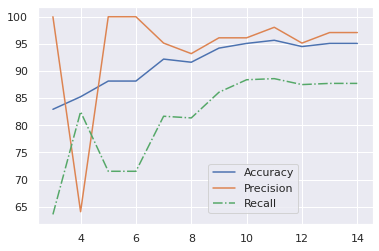

In [ ]:
# Visualize the result by line chart
plt.plot(final_result_1["Max_depth"], final_result_1["Accuracy"], label = "Accuracy")
plt.plot(final_result_1["Max_depth"], final_result_1["Precision"], label = "Precision",linestyle="-")
plt.plot(final_result_1["Max_depth"], final_result_1["Recall"], label = "Recall",linestyle="-.")
plt.legend(loc=(0.51, 0.05)) ## Modify the position of legend
plt.show()

In [ ]:
if __name__ == '__main__':
    model = DecisionTree(max_depth= 11)
    model.fit(X = x_train, y = "class")
    the_prediction = model.predict(x_test)

<ipython-input-87-dce03d333b15>:51: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  for column in dataset.drop([class_column],1).columns.tolist():


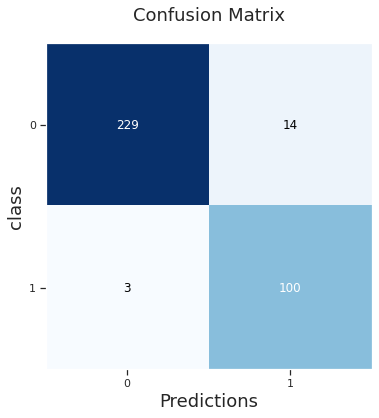

In [ ]:
## Draw confusionm matrix chart
confusion_matrix = conf_mat(the_prediction)
class_names = ["0","1"]
fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, figsize=(6, 6), cmap=plt.cm.Blues)
## Change label name
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('class', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
## Change value name
ax.set_xticklabels(['', '0', '1'])
ax.set_yticklabels(['', '0', '1']);
plt.show()